# agenet, gendernet

In [23]:
import cv2 as cv2
import math
import time
from imutils import face_utils
import numpy as np
import imutils
import dlib
import cv2
import matplotlib.pyplot as plt
import face_recognition
import os
from imutils import paths

def imshow(tit, image) :
    plt.title(tit)    
    if len(image.shape) == 3 :
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    else :
        plt.imshow(image, cmap="gray")
    plt.show()

In [24]:
def getFaceBox(net, frame, conf_threshold=0.7):
    frameOpencvDnn = frame.copy()
    frameHeight = frameOpencvDnn.shape[0]
    frameWidth = frameOpencvDnn.shape[1]
    
    blob = cv2.dnn.blobFromImage(frameOpencvDnn, 
                                1.0,  # normalization 안하겠다(0~255)
                                (300, 300), # input shape
                                [104, 117, 123], # 평균에서 뺄값 (RGB의 평균감)
                                True, False)

    net.setInput(blob)
    detections = net.forward()
    bboxes = []
    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > conf_threshold:
            x1 = int(detections[0, 0, i, 3] * frameWidth)
            y1 = int(detections[0, 0, i, 4] * frameHeight)
            x2 = int(detections[0, 0, i, 5] * frameWidth)
            y2 = int(detections[0, 0, i, 6] * frameHeight)
            bboxes.append([x1, y1, x2, y2])
            cv2.rectangle(frameOpencvDnn, (x1, y1), (x2, y2), (0, 255, 0), int(round(frameHeight/150)), 8)
    return frameOpencvDnn, bboxes

## 학습시킨 모델

In [25]:
faceProto = "./agegender/opencv_face_detector.pbtxt"
faceModel = "./agegender/opencv_face_detector_uint8.pb"

ageProto = "./agegender/age_deploy.prototxt"
ageModel = "./agegender/age_net.caffemodel"

genderProto = "./agegender/gender_deploy.prototxt"
genderModel = "./agegender/gender_net.caffemodel"

ageList = ['(0-2)', '(4-6)', '(8-12)', '(15-20)', '(25-32)', '(38-43)', '(48-53)', '(60-100)']
genderList = ['Male', 'Female']

# Load network
ageNet = cv2.dnn.readNet(ageModel, ageProto)
genderNet = cv2.dnn.readNet(genderModel, genderProto)
faceNet = cv2.dnn.readNet(faceModel, faceProto)

## bomb에서 평균값 구한 이미지

In [38]:
frame = cv2.imread("./images/sample1.jpg")
frameFace, bboxes = getFaceBox(faceNet, frame)
# 얼굴의 범위를 넓혀주는 범위의 값
padding=10
for bbox in bboxes:
    # 얼굴 자르기
        face = frame[max(0,bbox[1]-padding):min(bbox[3]+padding,frame.shape[0]-1),max(0,bbox[0]-padding):min(bbox[2]+padding, frame.shape[1]-1)]

        blob = cv2.dnn.blobFromImage(face, 1.0, (227, 227),(78.4263377603, 87.7689143744, 114.895847746), swapRB=False)
        genderNet.setInput(blob)
        genderPreds = genderNet.forward()
        gender = genderList[genderPreds[0].argmax()]
        print("Gender : {}, conf = {:.3f}".format(gender, genderPreds[0].max()))

        ageNet.setInput(blob)
        agePreds = ageNet.forward()
        age = ageList[agePreds[0].argmax()]
        print("Age Output : {}".format(agePreds))
        print("Age : {}, conf = {:.3f}".format(age, agePreds[0].max()))

        label = "{},{}".format(gender, age)
        cv2.putText(frameFace, label, (bbox[0], bbox[1]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 255), 2, cv2.LINE_AA)        
        # cv.imwrite("age-gender-out-{}".format(args.input),frameFace)

Gender : Male, conf = 1.000
Age Output : [[5.0422677e-05 6.6032046e-03 9.9196303e-01 9.0643363e-05 1.2083673e-03
  4.4209090e-05 2.6494012e-05 1.3531237e-05]]
Age : (8-12), conf = 0.992
Gender : Male, conf = 1.000
Age Output : [[9.8923862e-01 1.0366707e-02 3.6442763e-04 2.6064206e-06 1.5998328e-05
  7.6123233e-06 1.7588355e-06 2.2897334e-06]]
Age : (0-2), conf = 0.989
Gender : Female, conf = 0.950
Age Output : [[1.65868153e-06 1.00786008e-06 1.11874564e-04 3.56943841e-04
  9.99294400e-01 2.22708652e-04 9.56830445e-06 1.78582150e-06]]
Age : (25-32), conf = 0.999


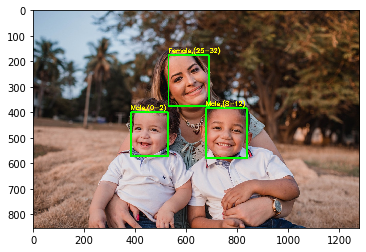

In [39]:
imshow('', frameFace)

# 내 사진 예측

In [36]:
frame = cv2.imread("./images/my.jpg")
frameFace, bboxes = getFaceBox(faceNet, frame)
# 얼굴의 범위를 넓혀주는 범위의 값 : 100이 되니 정확도가 높아짐!
padding=100
for bbox in bboxes:
    # 얼굴 자르기
        face = frame[max(0,bbox[1]-padding):min(bbox[3]+padding,frame.shape[0]-1),max(0,bbox[0]-padding):min(bbox[2]+padding, frame.shape[1]-1)]

        blob = cv2.dnn.blobFromImage(face, 1.0, (227, 227),(78.4263377603, 87.7689143744, 114.895847746), swapRB=False)
        genderNet.setInput(blob)
        genderPreds = genderNet.forward()
        gender = genderList[genderPreds[0].argmax()]
        print("Gender : {}, conf = {:.3f}".format(gender, genderPreds[0].max()))

        ageNet.setInput(blob)
        agePreds = ageNet.forward()
        age = ageList[agePreds[0].argmax()]
        print("Age Output : {}".format(agePreds))
        print("Age : {}, conf = {:.3f}".format(age, agePreds[0].max()))

        label = "{},{}".format(gender, age)
        cv2.putText(frameFace, label, (bbox[0], bbox[1]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 255), 2, cv2.LINE_AA)        
        # cv.imwrite("age-gender-out-{}".format(args.input),frameFace)

Gender : Female, conf = 0.999
Age Output : [[1.2540973e-04 7.2578252e-05 3.1857411e-03 2.6058519e-02 7.8587246e-01
  1.7238443e-01 7.5566852e-03 4.7441954e-03]]
Age : (25-32), conf = 0.786


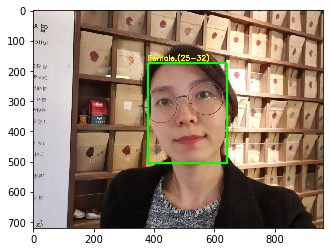

In [37]:
imshow('', frameFace)

In [40]:
frame = cv2.imread("./images/face3.jpg")
frameFace, bboxes = getFaceBox(faceNet, frame)
# 얼굴의 범위를 넓혀주는 범위의 값
padding=100
for bbox in bboxes:
    # 얼굴 자르기
        face = frame[max(0,bbox[1]-padding):min(bbox[3]+padding,frame.shape[0]-1),max(0,bbox[0]-padding):min(bbox[2]+padding, frame.shape[1]-1)]

        blob = cv2.dnn.blobFromImage(face, 1.0, (227, 227),(78.4263377603, 87.7689143744, 114.895847746), swapRB=False)
        genderNet.setInput(blob)
        genderPreds = genderNet.forward()
        gender = genderList[genderPreds[0].argmax()]
        print("Gender : {}, conf = {:.3f}".format(gender, genderPreds[0].max()))

        ageNet.setInput(blob)
        agePreds = ageNet.forward()
        age = ageList[agePreds[0].argmax()]
        print("Age Output : {}".format(agePreds))
        print("Age : {}, conf = {:.3f}".format(age, agePreds[0].max()))

        label = "{},{}".format(gender, age)
        cv2.putText(frameFace, label, (bbox[0], bbox[1]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 255), 2, cv2.LINE_AA)        
        # cv.imwrite("age-gender-out-{}".format(args.input),frameFace)

Gender : Male, conf = 1.000
Age Output : [[6.9110442e-06 1.4907569e-05 1.8537129e-04 2.0367741e-03 2.1724647e-02
  9.7566313e-01 2.2257156e-04 1.4560118e-04]]
Age : (38-43), conf = 0.976


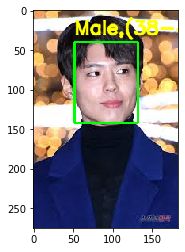

In [41]:
imshow('', frameFace)

In [32]:
frame = cv2.imread("./images/group.jpg")
frameFace, bboxes = getFaceBox(faceNet, frame)
# 얼굴의 범위를 넓혀주는 범위의 값
padding=10
for bbox in bboxes:
    # 얼굴 자르기
        face = frame[max(0,bbox[1]-padding):min(bbox[3]+padding,frame.shape[0]-1),max(0,bbox[0]-padding):min(bbox[2]+padding, frame.shape[1]-1)]

        blob = cv2.dnn.blobFromImage(face, 1.0, (227, 227),(78.4263377603, 87.7689143744, 114.895847746), swapRB=False)
        genderNet.setInput(blob)
        genderPreds = genderNet.forward()
        gender = genderList[genderPreds[0].argmax()]
        print("Gender : {}, conf = {:.3f}".format(gender, genderPreds[0].max()))

        ageNet.setInput(blob)
        agePreds = ageNet.forward()
        age = ageList[agePreds[0].argmax()]
        print("Age Output : {}".format(agePreds))
        print("Age : {}, conf = {:.3f}".format(age, agePreds[0].max()))

        label = "{},{}".format(gender, age)
        cv2.putText(frameFace, label, (bbox[0], bbox[1]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 255), 2, cv2.LINE_AA)        
        # cv.imwrite("age-gender-out-{}".format(args.input),frameFace)

Gender : Female, conf = 0.988
Age Output : [[1.6757785e-05 1.8384447e-04 1.2528577e-01 8.3533609e-01 3.1428203e-02
  6.8470477e-03 6.6787883e-04 2.3437431e-04]]
Age : (15-20), conf = 0.835
Gender : Female, conf = 0.993
Age Output : [[7.8095667e-07 2.0309203e-06 3.8279901e-05 1.8885903e-03 9.8546010e-01
  1.2523356e-02 5.3400701e-05 3.3361452e-05]]
Age : (25-32), conf = 0.985
Gender : Male, conf = 0.918
Age Output : [[1.46870525e-05 5.93868863e-05 2.25623441e-03 2.37280622e-01
  7.37532020e-01 2.27234829e-02 6.80441008e-05 6.56186603e-05]]
Age : (25-32), conf = 0.738


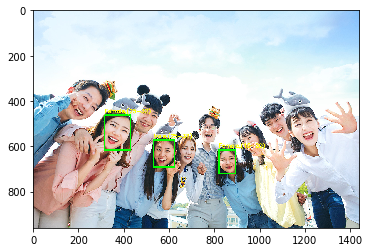

In [33]:
imshow('', frameFace)

- 얼굴 검출은 잘 안됨...
- 성별 예측은 성능이 좋지만
- 나이는 글쎙